<a href="https://colab.research.google.com/github/PranavTJ-05/E-waste-Generation-classification/blob/main/E_waste_Generation_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B3  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations


In [ ]:
testpath= r'/content/drive/MyDrive/modified-dataset/test'
trainpath= r'/content/drive/MyDrive/modified-dataset/train'
validpath = r'/content/drive/MyDrive/modified-dataset/val'

In [ ]:
datatrain = tf.keras.utils.image_dataset_from_directory(
    trainpath,
    shuffle=True,
    image_size=(300, 300),  # CHANGED
    batch_size=24,          # REDUCED
    validation_split=False
)

Found 2430 files belonging to 10 classes.


In [ ]:
datatest = tf.keras.utils.image_dataset_from_directory(
    testpath,
    shuffle=False,
    image_size=(300, 300),  # CHANGED
    batch_size=16,          # REDUCED
    validation_split=False
)

Found 300 files belonging to 10 classes.


In [ ]:
datavalid = tf.keras.utils.image_dataset_from_directory(
    validpath,
    shuffle=True,
    image_size=(300, 300),  # CHANGED
    batch_size=16,          # REDUCED
    validation_split=False
)

Found 300 files belonging to 10 classes.


In [ ]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


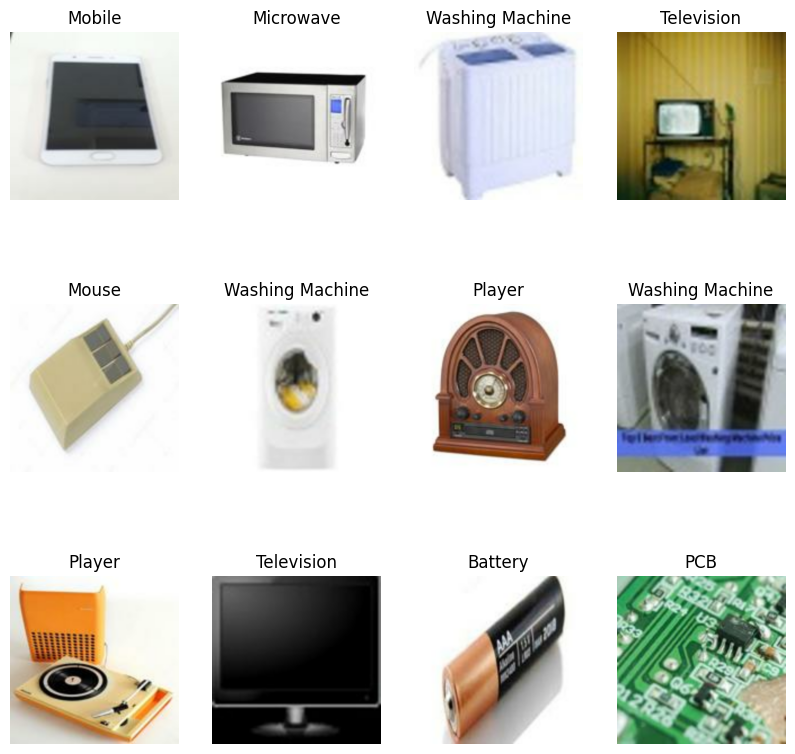

In [ ]:
# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(3, 4, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")

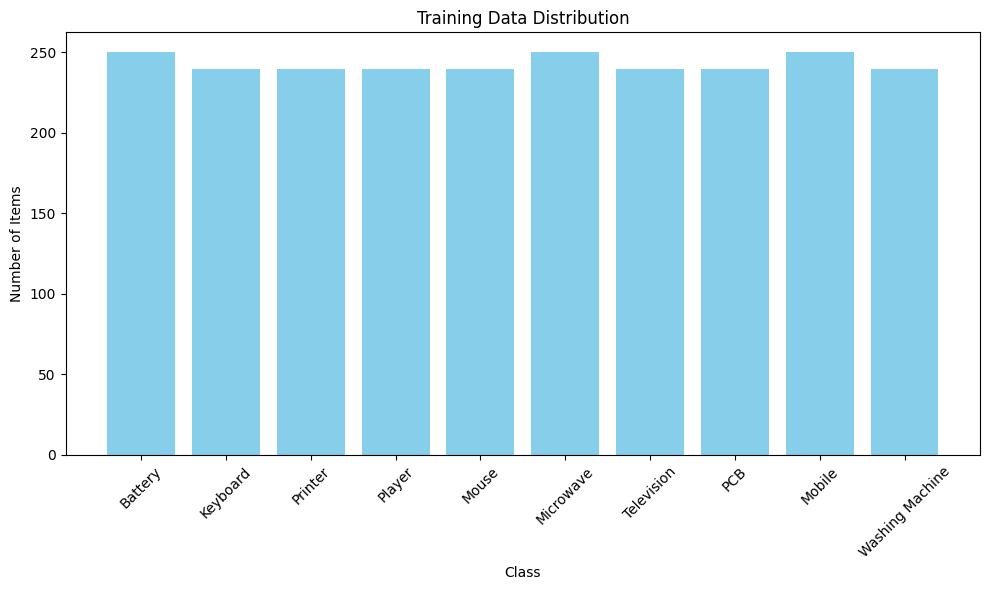

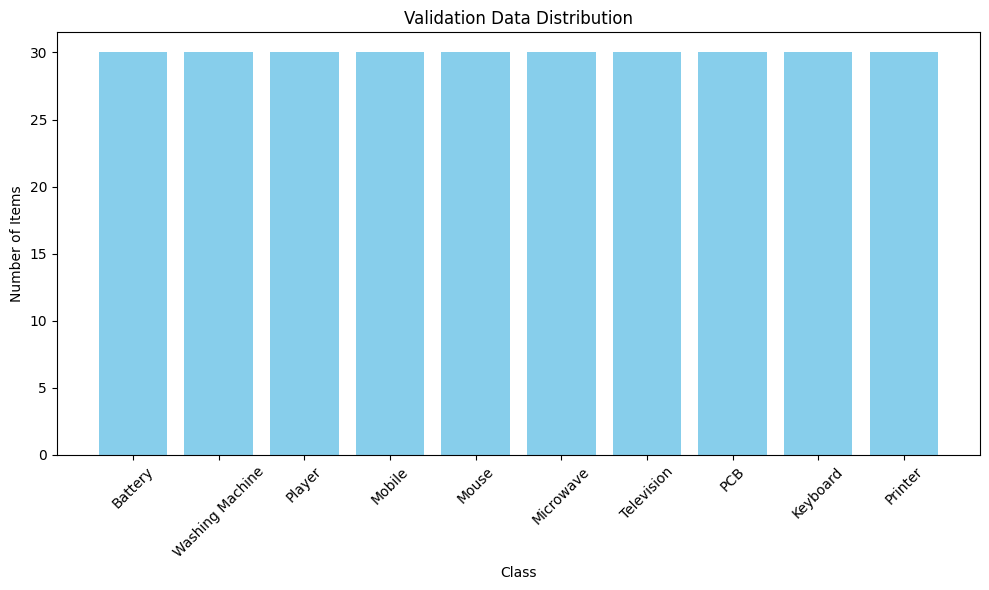

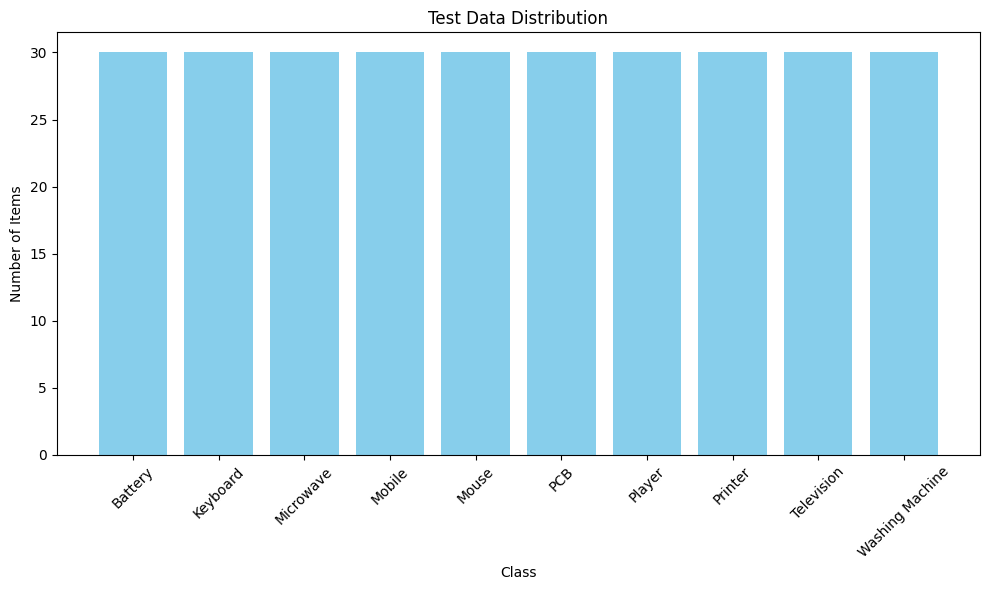

In [ ]:
def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        title: Title for the plot (e.g., 'Train Data Distribution')
    """

    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            # Increment the count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    # Prepare data for plotting
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class

    # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot

plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

In [ ]:

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B3(
    input_shape=(300, 300, 3),  # B3 optimal input size
    include_top=False,
    weights='imagenet'
)

52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = True

# Smart freezing: Freeze 75% of layers for B3 stability
total_layers = len(base_model.layers)
freeze_until = int(total_layers * 0.75)

for i, layer in enumerate(base_model.layers):
    if i < freeze_until:
        layer.trainable = False
    # Keep BatchNormalization layers frozen for stability
    elif isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

print(f"Total layers in EfficientNetV2B3: {total_layers}")
print(f"Frozen layers: {freeze_until}")
print(f"Trainable layers: {sum(1 for layer in base_model.layers if layer.trainable)}")

Total layers in EfficientNetV2B3: 409
Frozen layers: 306
Trainable layers: 83


In [ ]:
# Model Architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(300, 300, 3)),  # Updated input shape
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),  # Increased dropout for larger model
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
# Compilation with adjusted learning rate for B3
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),  # Lower LR for larger model
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']  # Changed from 'Accuracy' to 'accuracy'
)

In [ ]:
# Enhanced callbacks for B3
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Increased patience for larger model
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# Learning rate reduction callback
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    min_lr=0.000001,
    verbose=1
)

In [ ]:
# Model checkpoint to save best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_efficientnetv2b3_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
# Training parameters
epochs = 20  # Increased epochs for B3
batch_size = 24  # Reduced batch size for memory efficiency

# Train the model
print("Starting training with EfficientNetV2B3...")
history = model.fit(
    datatrain,
    validation_data=datavalid,
    epochs=epochs,
    batch_size=batch_size,  # Smaller batch size for B3
    callbacks=[early_stopping, lr_reduction, checkpoint],  # Enhanced callbacks
    verbose=1
)

Starting training with EfficientNetV2B3...
Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4486 - loss: 1.7698
Epoch 1: val_accuracy improved from -inf to 0.95667, saving model to best_efficientnetv2b3_model.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 803s 8s/step - accuracy: 0.4507 - loss: 1.7646 - val_accuracy: 0.9567 - val_loss: 0.1757 - learning_rate: 5.0000e-05
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8853 - loss: 0.4028
Epoch 2: val_accuracy improved from 0.95667 to 0.97000, saving model to best_efficientnetv2b3_model.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 734s 7s/step - accuracy: 0.8855 - loss: 0.4022 - val_accuracy: 0.9700 - val_loss: 0.0819 - learning_rate: 5.0000e-05
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9313 - loss: 0.2256
Epoch 3: val_accuracy improved from 0.97000 to 0.98000, saving model to best_efficientnetv2b3_model.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 740s 7s/step - accuracy: 0.9314 - loss: 0.2255 - val_accuracy: 0.9800 - val_loss: 0.0560 - learning_rate: 5.0000e-05
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9504 - loss: 0.1616
Epoch 4: val_accuracy did not improve from 0.98000
102/102 ━━━━━━━━━━━━━━━━━━━━ 744s 7s/step - accuracy: 0.9504 - loss: 0.1616 - val_accuracy: 0.9767 - val_loss: 0.0473 - learning_rate: 5.0000e-05
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9645 - loss: 0.1381
Epoch 5: val_accuracy improved from 0.98000 to 0.98333, saving model to best_efficientnetv2b3_model.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 776s 8s/step - accuracy: 0.9644 - loss: 0.1381 - val_accuracy: 0.9833 - val_loss: 0.0419 - learning_rate: 5.0000e-05
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9605 - loss: 0.1303
Epoch 6: val_accuracy improved from 0.98333 to 0.98667, saving model to best_efficientnetv2b3_model.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 790s 7s/step - accuracy: 0.9605 - loss: 0.1302 - val_accuracy: 0.9867 - val_loss: 0.0465 - learning_rate: 5.0000e-05
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9707 - loss: 0.1028
Epoch 7: val_accuracy did not improve from 0.98667
102/102 ━━━━━━━━━━━━━━━━━━━━ 776s 7s/step - accuracy: 0.9707 - loss: 0.1027 - val_accuracy: 0.9833 - val_loss: 0.0450 - learning_rate: 5.0000e-05
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9818 - loss: 0.0645
Epoch 8: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 8: val_accuracy did not improve from 0.98667
102/102 ━━━━━━━━━━━━━━━━━━━━ 743s 7s/step - accuracy: 0.9817 - loss: 0.0646 - val_accuracy: 0.9733 - val_loss: 0.0470 - learning_rate: 5.0000e-05
Epoch 9/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9795 - loss: 0.0652
Epoch 9: val_accuracy did not improve from 0.98667
102/102 ━━━━━━━━━━━━━━━━━━━━ 741s 7s/step - accuracy: 0.9795 - loss: 0.0651 -

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 10, 10, 1536)   │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        15,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,517,226 (93.53 MB)

 Trainable params: 5,785,616 (22.07 MB)

 Non-trainable params: 7,160,376 (27.31 MB)

 Optimizer params: 11,571,234 (44.14 MB)

In [ ]:
base_model.summary()

Model: "efficientnetv2-b3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ normalization[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │      5,760 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 150, 150,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 150, 150,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 150, 150,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 150, 150,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 150, 150,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 150, 150,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 150, 150,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 75, 75,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 75, 75,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 75, 75,    │          0 │ block2a_expand_b

 Total params: 12,930,622 (49.33 MB)

 Trainable params: 5,770,246 (22.01 MB)

 Non-trainable params: 7,160,376 (27.31 MB)

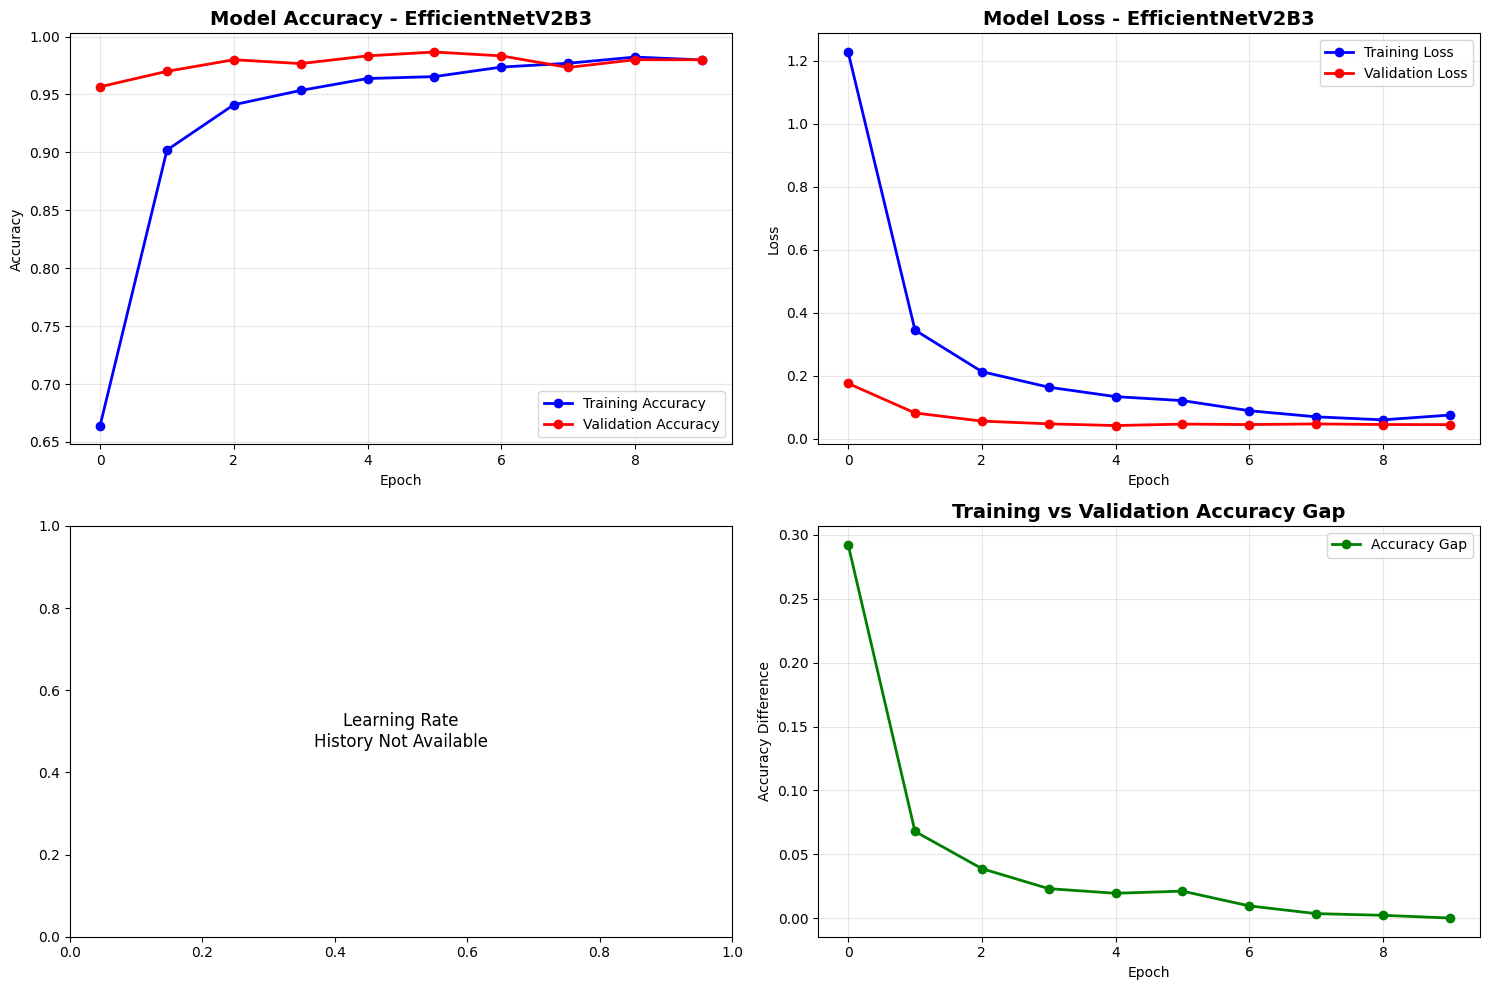

In [ ]:
def plot_training_history(history):
    """Enhanced training history visualization"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    epochs_range = range(len(history.history['accuracy']))

    # Plot accuracy
    ax1.plot(epochs_range, history.history['accuracy'], 'bo-', label='Training Accuracy', linewidth=2)
    ax1.plot(epochs_range, history.history['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy - EfficientNetV2B3', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot loss
    ax2.plot(epochs_range, history.history['loss'], 'bo-', label='Training Loss', linewidth=2)
    ax2.plot(epochs_range, history.history['val_loss'], 'ro-', label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss - EfficientNetV2B3', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot learning rate (if available)
    if 'lr' in history.history:
        ax3.plot(epochs_range, history.history['lr'], 'go-', linewidth=2)
        ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'Learning Rate\nHistory Not Available',
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        ax3.set_xlim(0, 1)
        ax3.set_ylim(0, 1)

    # Plot accuracy difference
    acc_diff = [abs(train - val) for train, val in zip(history.history['accuracy'], history.history['val_accuracy'])]
    ax4.plot(epochs_range, acc_diff, 'go-', linewidth=2, label='Accuracy Gap')
    ax4.set_title('Training vs Validation Accuracy Gap', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy Difference')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)


In [ ]:
# Print final training results
print("\n" + "="*60)
print("TRAINING COMPLETED - EWASTE CLASSIFICATION")
print("="*60)
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Total Epochs Trained: {len(history.history['accuracy'])}")
print(f"Model saved as: best_efficientnetv2b3_ewaste_model.h5")


TRAINING COMPLETED - EWASTE CLASSIFICATION
Final Training Accuracy: 0.9798
Final Validation Accuracy: 0.9800
Best Validation Accuracy: 0.9867
Total Epochs Trained: 10
Model saved as: best_efficientnetv2b3_ewaste_model.h5


In [ ]:
# Calculate overfitting metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
overfitting_gap = final_train_acc - final_val_acc

print(f"\nModel Performance Analysis:")
print(f"Overfitting gap: {overfitting_gap:.4f}")
if overfitting_gap < 0.05:
    print("✅ Good generalization - Low overfitting")
elif overfitting_gap < 0.1:
    print("⚠️ Moderate overfitting")
else:
    print("❌ High overfitting - Consider regularization")

print("="*60)

# Memory optimization tips
print("\n" + "="*50)
print("MEMORY OPTIMIZATION TIPS FOR 300x300 IMAGES")
print("="*50)
print("If you encounter memory issues:")
print("1. Reduce batch_size further (try 12 or 8)")
print("2. Use mixed precision: tf.keras.mixed_precision.set_global_policy('mixed_float16')")
print("3. Clear GPU memory: tf.keras.backend.clear_session()")
print("4. Use gradient accumulation for effective larger batch sizes")
print("5. Consider using tf.data for more efficient data loading")
print("="*50)


Model Performance Analysis:
Overfitting gap: -0.0002
✅ Good generalization - Low overfitting

MEMORY OPTIMIZATION TIPS FOR 300x300 IMAGES
If you encounter memory issues:
1. Reduce batch_size further (try 12 or 8)
2. Use mixed precision: tf.keras.mixed_precision.set_global_policy('mixed_float16')
3. Clear GPU memory: tf.keras.backend.clear_session()
4. Use gradient accumulation for effective larger batch sizes
5. Consider using tf.data for more efficient data loading



Generating predictions for confusion matrix...
19/19 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step

Confusion Matrix:
[[28  0  0  0  0  0  0  1  0  1]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0]
 [ 1  0  0  0  0 29  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0]
 [ 0  0  1  0  1  0  0  0 28  0]
 [ 1  0  0  0  0  0  0  0  0 29]]

Classification Report:
                 precision    recall  f1-score   support

        Battery       0.93      0.93      0.93        30
       Keyboard       1.00      1.00      1.00        30
      Microwave       0.97      1.00      0.98        30
         Mobile       1.00      1.00      1.00        30
          Mouse       0.97      1.00      0.98        30
            PCB       1.00      0.97      0.98        30
         Player       1.00      1.00      1.00        30
        Printer       0.97      1.00      0.98        30
     Television       1.0

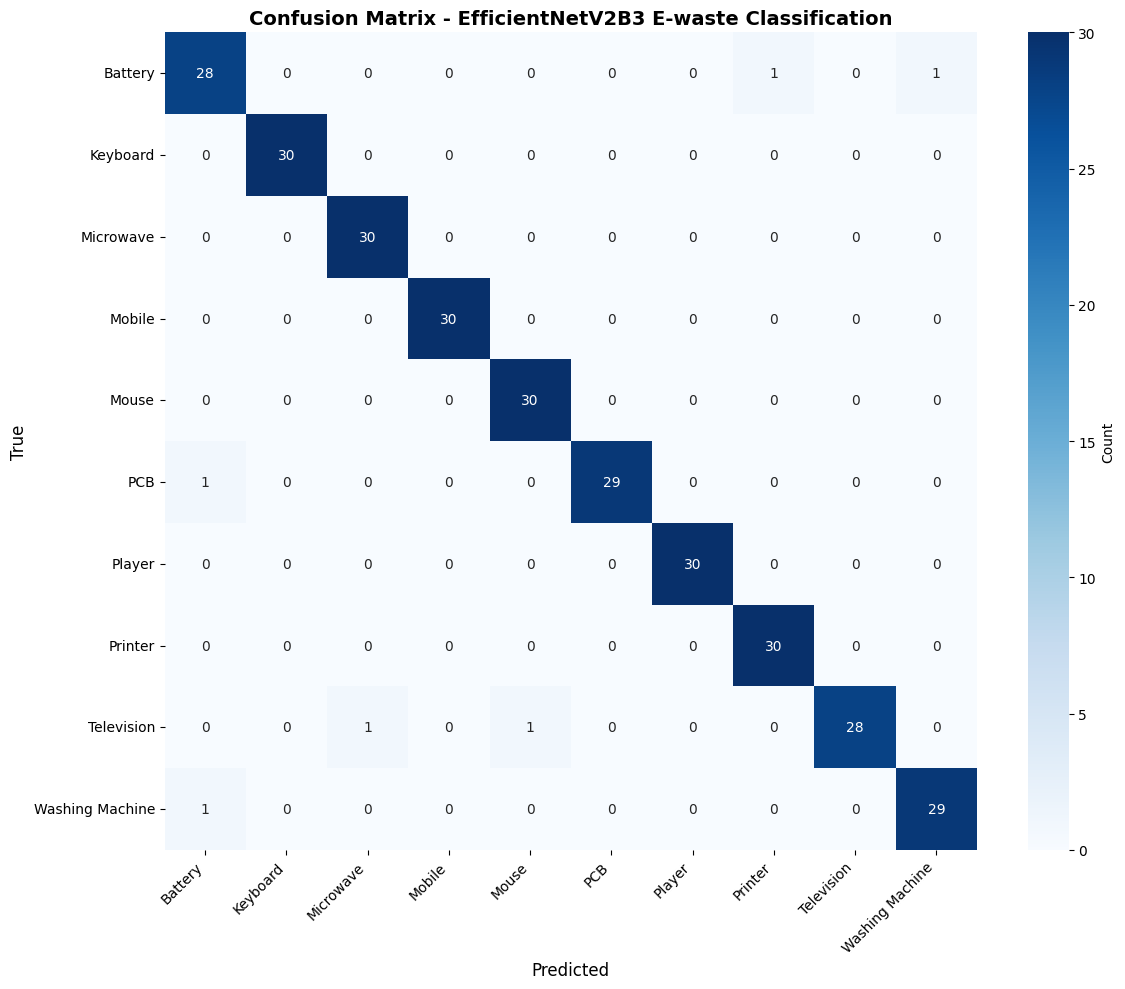

In [ ]:
print("\nGenerating predictions for confusion matrix...")
# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Print confusion matrix and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix

plt.figure(figsize=(12, 10))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues',
            cbar_kws={'label': 'Count'})                                               # Create heatmap with class labels

plt.xlabel('Predicted', fontsize=12)                                                   # Label for x-axis
plt.ylabel('True', fontsize=12)                                                        # Label for y-axis
plt.title('Confusion Matrix - EfficientNetV2B3 E-waste Classification', fontsize=14, fontweight='bold')                                             # Title for the plot
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Efficient_classify_v2b3.keras')
print("Model saved as: Efficient_classify_v2b3.keras")

Model saved as: Efficient_classify_v2b3.keras


In [ ]:
!pip install gradio

In [32]:
def classify_image(img):
    """
    Updated classify function for EfficientNetV2B3 with 300x300 input
    """
    # Step 1: Resize to 300x300 and convert to array
    img = img.resize((300, 300))  # Updated size for EfficientNetV2B3
    img_array = np.array(img, dtype=np.float32)

    # Step 2: Normalize pixel values to [0,1]
    img_array = img_array / 255.0

    # Step 3: Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Step 4: Predict using the model
    prediction = model.predict(img_array)
    index = np.argmax(prediction)  # Get index of highest score

    # Step 5: Get class name and confidence
    class_name = class_names_gradio[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"

# Create a Gradio interface for the classify_image function
print("\nSetting up Gradio interface...")
iface = gr.Interface(
    fn=classify_image,          # The function to run when input is given
    inputs=gr.Image(type="pil"), # Input component: expects an image as a PIL object
    outputs="text",              # Output component: displays the result as plain text
    title="E-waste Classification - EfficientNetV2B3",
    description="Upload an image of electronic waste to classify it into one of the 10 categories.",
    examples=None  # You can add example images here if needed
)

# Launch the Gradio interface, opening a local web app to interact with the model
print("Launching Gradio interface...")
iface.launch()


Setting up Gradio interface...
Launching Gradio interface...
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5c6da784f09c423aa4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
